This was my attempt to load data with the openweathermap API, but I found that historical data was behind a paywall, so I abandoned it. 
``` python
import requests

# Gets current weather - API KEY workds
url = "https://api.openweathermap.org/data/2.5/weather?q=Buffalo&APPID=5660de03d00e114adaf6ed3657b397c5"

# Gets weather history - paid service, so API_KEY appears invalid. 
#url = "http://history.openweathermap.org/data/2.5/history/city?id=200&type=hour&start=1369728000&end=1369789200&appid=5660de03d00e114adaf6ed3657b397c5"

response = requests.get(url)

data = response.json()
data
```

New Plan: I downloaded data from [NOAA](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd) and saved it to `BuffaloWeather_2001-2020.csv`. Let's see what we can do with that. 

In [21]:
# Manage all imports for the notebook
from datetime import datetime
import math
import calendar
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange, date2num)

# For interactive mode, use this magic command.
# Note - doesn't work in Jupyter Labs
# %matplotlib nbagg
# plt.ion()

sns.set()  # use Seaborn styles

In [22]:
with open('BuffaloWeather_2001-2020.csv') as f:
    data = pd.read_csv(f,dtype=str)
    # Note: I could specify a dtype for each column with a dict like {"user_id": int,...}
    # but the number of unnecessary columns here makes me feel that it's not worth it in this case. 
    
data

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72528014733,2001-01-01T00:00:00,NSRDB,9,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72528014733,2001-01-01T00:54:00,FM-15,4,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72528014733,2001-01-01T01:00:00,SY-MT,3,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72528014733,2001-01-01T01:54:00,FM-15,C,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72528014733,2001-01-01T02:00:00,NSRDB,9,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317721,72528014733,2020-08-09T20:54:00,FM-15,6,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317722,72528014733,2020-08-09T21:54:00,FM-15,6,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317723,72528014733,2020-08-09T22:54:00,FM-15,6,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317724,72528014733,2020-08-09T23:54:00,FM-15,6,NaN,ENE,1,mi,"PRECIP, SNOW",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


``` python
for c in list(data.columns):
    print(f'{list(data.columns).index(c)} - {c}')
```
After inspecting the columns with the code above, It looks to me like the following columns can be useful:
* `1 - DATE`
* `28 - DailyMaximumDryBulbTemperature`
* `29 - DailyMinimumDryBulbTemperature`
* `43 - HourlyDryBulbTemperature` (If I want to get really granular)

It seems like drybulb has more data available, and it should be fine. It's not necessarily reflecting comfort levels the same way a wet bulb temperature would be, but it's correlated so it should be fine for my purposes. 

If I were to use the hourly temperature, I'd have probably way to many data points. What's the spread like? Take note that the error after loading the csv says that column 43 has mixed data, so I'll need to do some transformation to make sure my `unique()` function works correctly. 

In [23]:
def isNumeric(val):
    '''
    Quick cheat for determining whether a value is numeric. 
    Return true only if it can be cast as a float and is not NaN. 
    '''
    try:
        return not math.isnan(float(val))
    except Exception as e:
        return False

# Get all data from the column, casting to a float or string depending on how numeric it seems
dbt = data['HourlyDryBulbTemperature'].transform(lambda x: float(x) if isNumeric(x) else str(x))

# Get unique values and counts
tempCounts = [(temp,list(dbt).count(temp)) for temp in list(dbt.unique())]

#Get the subset that is numeric
sub_nums = [(float(tup[0]),tup[1]) for tup in tempCounts if isNumeric(tup[0])]

# Get the subset that is not numeric
sub_others = [tup for tup in tempCounts if not isNumeric(tup[0])]

columns = ["Temperature","Count"]

# Numeric DataFrame
df_nums = pd.DataFrame(sub_nums, columns=columns)
df_nums.sort_values(
                    by = ['Temperature'],
                    inplace = True,
                    ascending = False)

# Non-Numeric DataFrame
df_others = pd.DataFrame(sub_others, columns=columns)
df_others.sort_values(
                    by = ['Count'],
                    inplace = True,
                    ascending = False)

# Show the non-numeric values
df_others

,Temperature,Count
0,nan,36239
3,*,6
5,79s,2
7,70s,2
1,50s,1
2,18s,1
4,71s,1
6,80s,1
8,92s,1


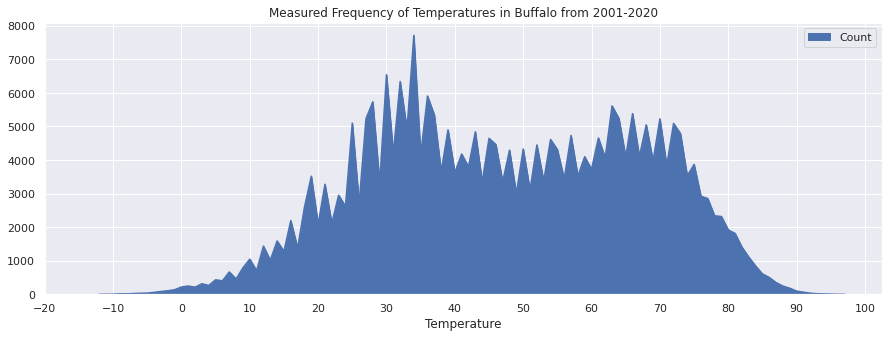

In [24]:
df_nums.plot(
    x="Temperature",
    y="Count",
    kind="area",
    title="Measured Frequency of Temperatures in Buffalo from 2001-2020",
    xticks=[i for i in range(-20,110,10)],
    figsize=(15,5))

Let's start working with the data on a larger scale. 

In [25]:
dateFormat = "%Y-%m-%dT%H:%M:%S"

all_dates = [datetime.strptime(d,dateFormat) for d in data["DATE"]]
all_temps = [float(t) if isNumeric(t) else None for t in data["HourlyDryBulbTemperature"]]

# zip lists so I can filter out the points without temperature data
temperature_data = [d for d in list(zip(all_dates,all_temps)) if d[1] is not None]

# unzip lists into x and y collections
dates, temps = list(zip(*temperature_data))

plotDates = [date2num(d) for d in dates]

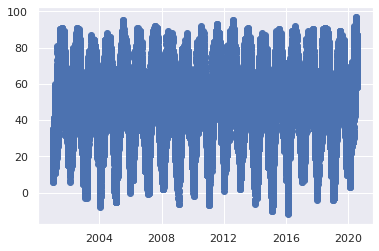

In [26]:
plt.plot_date(x=plotDates,y=temps)

Pulled the following example from [this matplotlib demo](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/date_demo_rrule.html#sphx-glr-gallery-ticks-and-spines-date-demo-rrule-py)

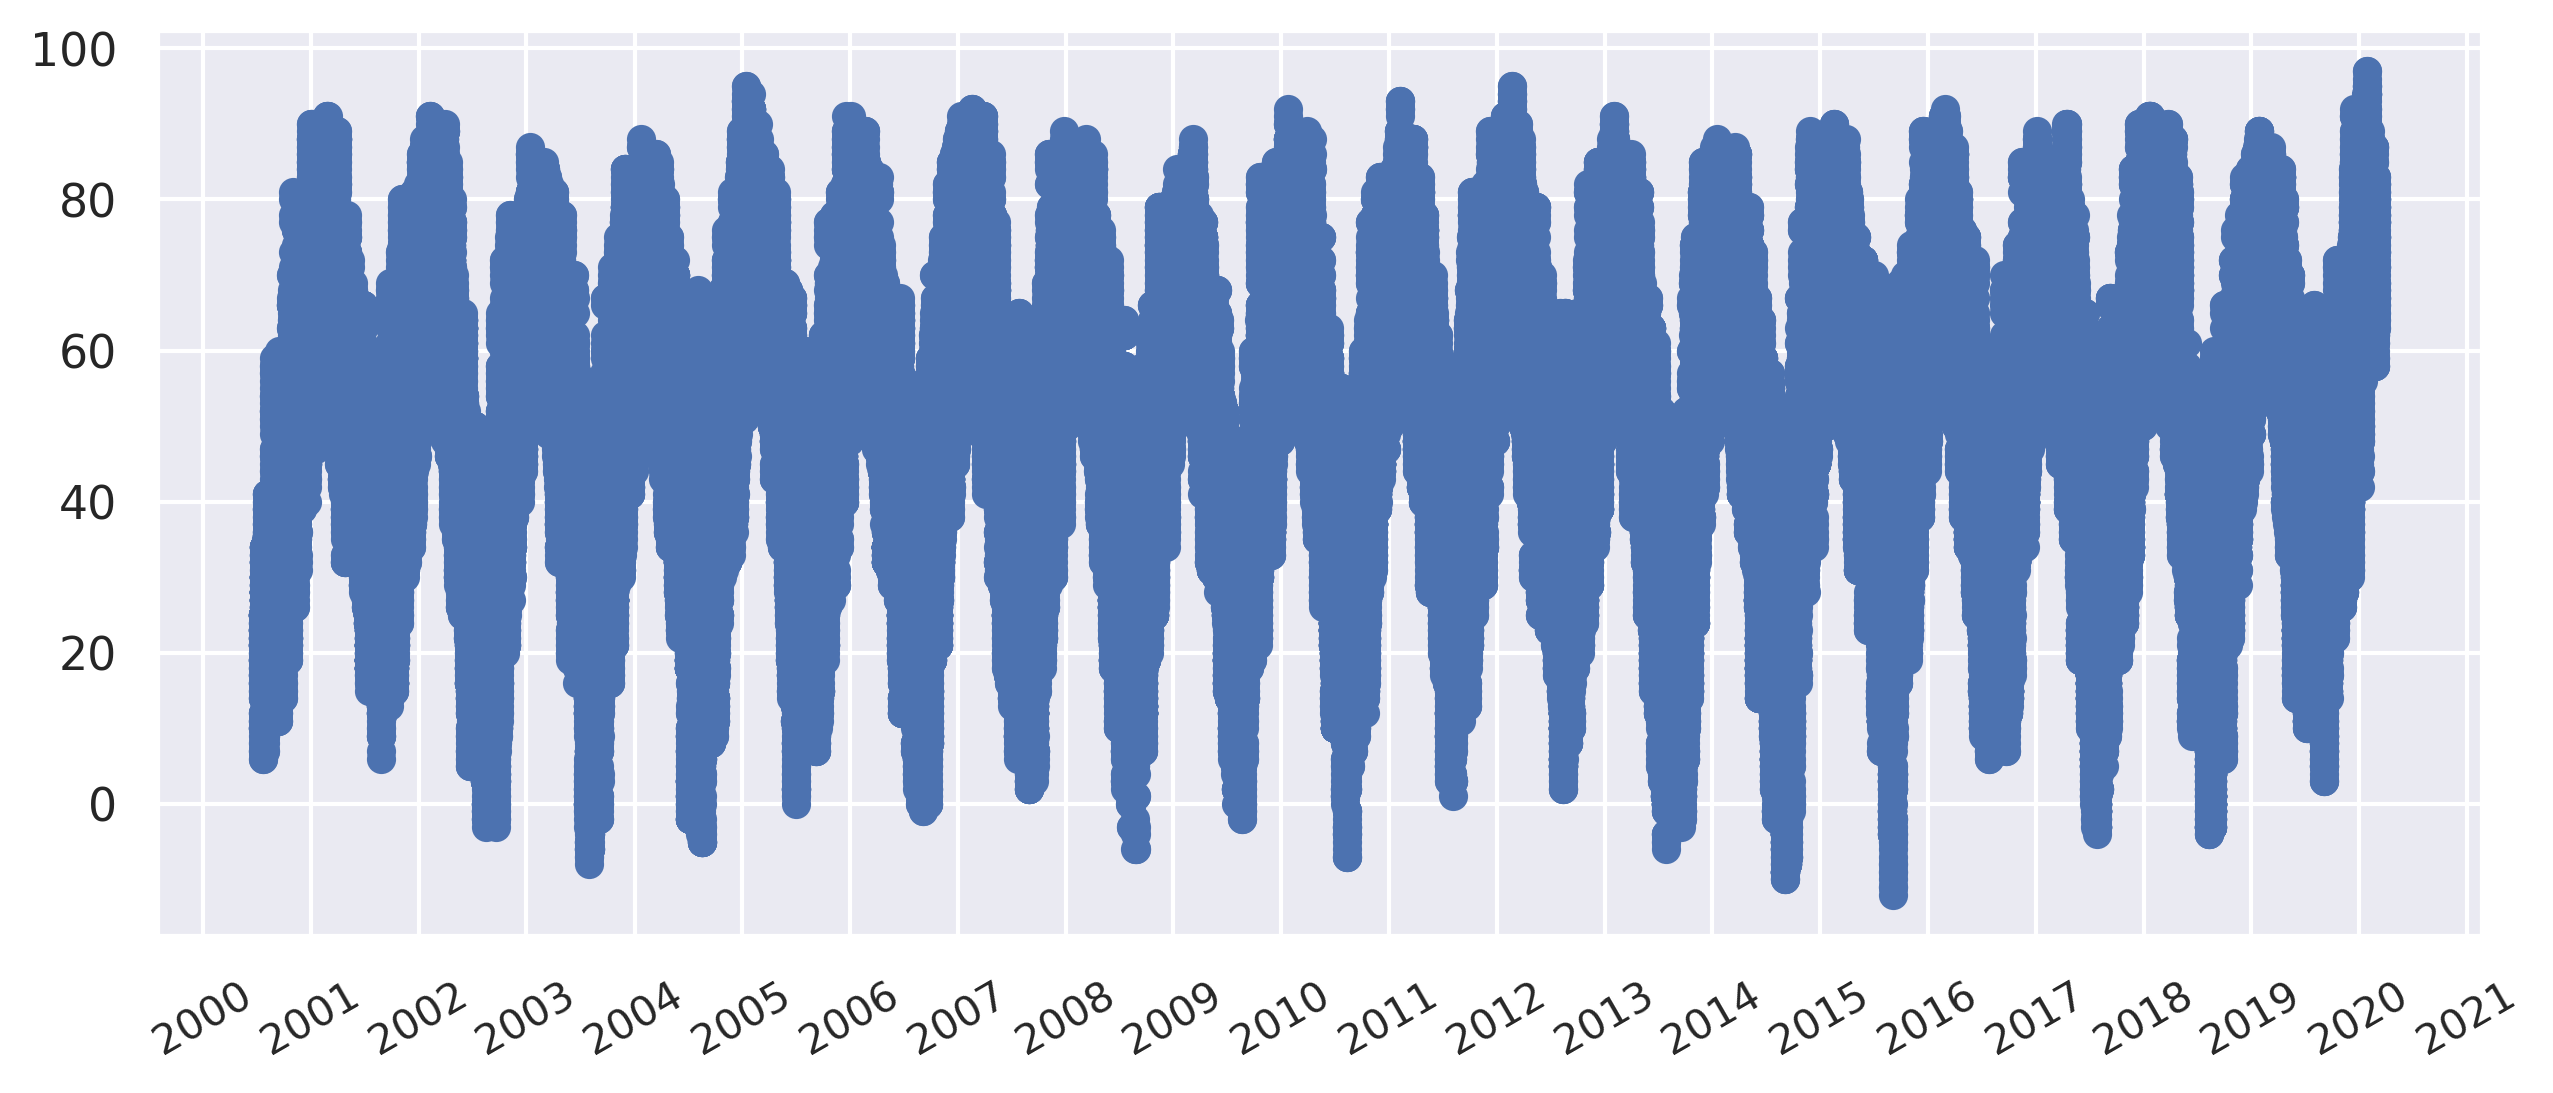

In [27]:
# tick every 5th year
rule = rrulewrapper(YEARLY, interval=1)
loc = RRuleLocator(rule)
# formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots()
plt.plot_date(plotDates, temps)
ax.xaxis.set_major_locator
ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

fig.set_dpi(300)
fig.set_figwidth(10)

plt.show()

So that's the date spread - makes sense, the temps rise and fall with seasons. I can already see that this summer appears abnormally warm. 

Next Steps:
* Break down the data by month/season
* Implement a way to show parallel seasons (overlapping lines with month/day on x axis?)

Let's start out by getting the data for specific months. I'll parameterize the month number and try to get a list of data arrays for that month. 

In [28]:
# I believe months are 1-indexed, so July is 7, August is 8, etc.  
target_month = 7

# Start with the zipped up and de-nulled temperature_data. 
monthTempsByYear = dict()

# Iteration seems clunky - perhaps this could be refactored with pandas 
for (d,t) in temperature_data:
    year = d.year
    month = d.month
    dayOfMonth = d.day
    if year not in monthTempsByYear.keys():
        monthTempsByYear[year] = []
    if month == target_month:
        monthTempsByYear[year].append((d,t))
    
# monthTempsByYear should now be a dict with year keys and tuple lists of data

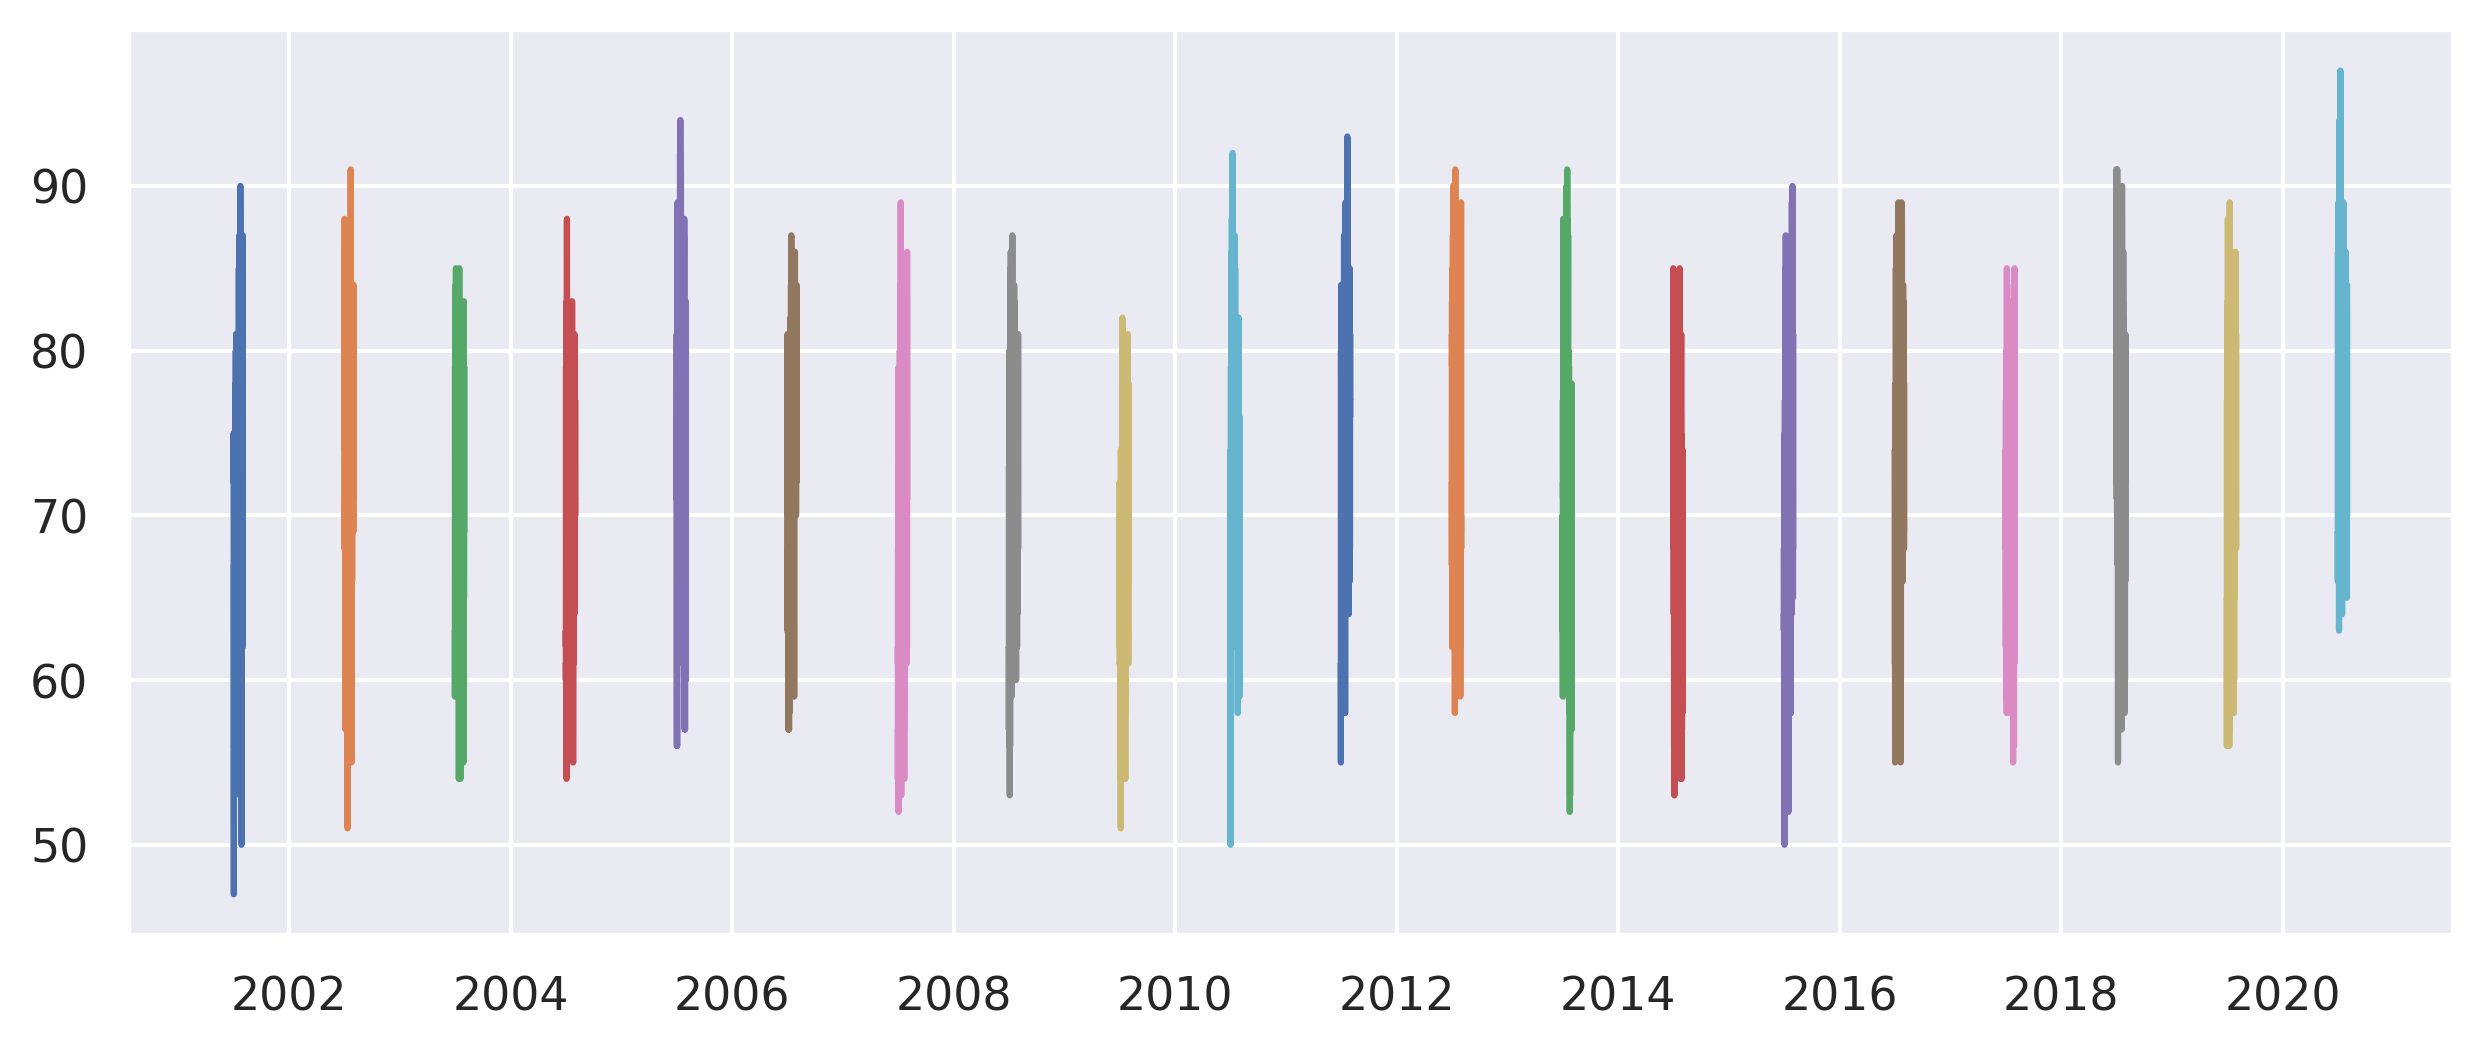

In [29]:
fig, ax = plt.subplots()
for year,yearData in monthTempsByYear.items():
    # unzip the yearData array of tuples into two arrays
    days, dayTemps = list(zip(*yearData))
    plt.plot(days,dayTemps)

fig.set_dpi(300)
fig.set_figwidth(10)

plt.show()

Haha So I see I forgot to strip the years from that data, so I'm just seeing the above data filtered to the target month. Pretty cool but not what I'm going for. 

I think [this page](http://atedstone.github.io/pandas-plot-seasons-time-series/) describes a doable way to process this data. Let's try it. 

In [30]:
# Get the relevant data lists
filtered_dates, filtered_temps = list(
    zip(
        *[(d,t) for (d,t) in temperature_data if d.month == target_month]))

for i in range(5):
    print(f'[{filtered_dates[i]}] -> [{filtered_temps[i]}]')
    

[2001-07-01 00:54:00] -> [73.0]
[2001-07-01 01:00:00] -> [74.0]
[2001-07-01 01:54:00] -> [73.0]
[2001-07-01 02:39:00] -> [72.0]
[2001-07-01 02:54:00] -> [72.0]


In [31]:
# Wrangle the data into a Series indexed by date
monthly_temp_series = pd.Series(filtered_temps, index = filtered_dates) 

# "smooth the time series by taking the mean over a rolling triangular window of width 3 values"
monthly_temp_series = monthly_temp_series.rolling(window=3, center=True, win_type='triang').mean()
monthly_temp_series.head()

2001-07-01 00:54:00      NaN
2001-07-01 01:00:00    73.50
2001-07-01 01:54:00    73.00
2001-07-01 02:39:00    72.25
2001-07-01 02:54:00    72.00
dtype: float64

In [32]:
# "Convert to a DataFrame and add two columns, one containing the day-of-year and the other the year"
# in my case, I want percent of month - easiest way to incorporate day and hour. 
monthly_temp_series.name = 'MonthlyTemperature'
df = monthly_temp_series.to_frame()
df['Progress'] = df.index.day+df.index.hour/24
df['Year'] = df.index.year

df

,MonthlyTemperature,Progress,Year
2001-07-01 00:54:00,NaN,1.000000,2001
2001-07-01 01:00:00,73.50,1.041667,2001
2001-07-01 01:54:00,73.00,1.041667,2001
2001-07-01 02:39:00,72.25,1.083333,2001
2001-07-01 02:54:00,72.00,1.083333,2001
...,...,...,...
2020-07-31 20:54:00,75.25,31.833333,2020
2020-07-31 21:54:00,73.00,31.875000,2020
2020-07-31 22:00:00,71.75,31.916667,2020
2020-07-31 22:54:00,71.00,31.916667,2020


In [33]:
# "Finally create a pivot table, which will have a column for each year in the data set and 
# a row for each day-of-year"
piv = pd.pivot_table(df, index=['Progress'],columns=['Year'], values=['MonthlyTemperature'])

piv

MonthlyTemperature                                                  \
Year                    2001    2002    2003    2004    2005    2006    2007   
Progress                                                                       
1.000000                 NaN  70.250  65.250  63.000  73.750  68.500  62.750   
1.041667              73.250  69.500  61.000  60.875  74.250  66.250  56.625   
1.083333              72.125  69.000  59.250  61.000  72.250  63.500  55.250   
1.125000              72.000  69.000  59.250  62.250  71.250  63.000  55.500   
1.166667              72.500  68.875  60.250  63.000  71.375  63.125  56.125   
...                      ...     ...     ...     ...     ...     ...     ...   
31.791667             77.250  76.000  76.875  73.250  76.125  79.500  79.250   
31.833333             74.250  74.750  74.000  72.000  73.250  79.000  76.000   
31.875000             72.750  74.000  72.250     NaN  71.500  79.000  74.500   
31.916667             71.250  73.250  70.750  71.000  70.875  79.500  73.250   
31.958333             70.500  70.500  67.500  71.500  69.750  74.250  69.250   

                                                                         \
Year         2008       2009    2010    2011       2012    2013    2014   
Progress                                                                  
1.000000   64.250  61.583333  57.250  62.500  73.000000  66.250  75.500   
1.041667   61.375  61.000000  53.500  59.250  71.500000  64.875  77.375   
1.083333   60.000  61.000000  53.000  56.500  70.750000  64.250  76.250   
1.125000   59.250  61.000000  53.000  56.000  70.250000  64.000  76.000   
1.166667   58.125  61.000000  52.750  55.625  68.875000  64.000  76.125   
...           ...        ...     ...     ...        ...     ...     ...   
31.791667  76.250  71.875000  70.375  77.500  72.375000  72.500  68.625   
31.833333  73.250  70.750000  69.000  77.000  71.000000  69.750  65.000   
31.875000  72.250  69.500000  68.250  77.000  70.250000  69.250  62.750   
31.916667  70.375  68.375000  67.875  76.875  69.750000  68.500  62.500   
31.958333  66.500  64.000000  65.750  75.250  68.416667  70.500  63.250   

                                                           
Year         2015    2016    2017    2018    2019    2020  
Progress                                                   
1.000000   63.750  62.750  68.750  75.250  66.750  68.750  
1.041667   63.500  61.375  69.375  76.750  62.625  68.125  
1.083333   63.000  61.250  69.250  74.750  58.500  67.250  
1.125000   63.000  61.000  69.000  72.750  57.250  66.500  
1.166667   63.000  62.000  68.625  72.250  56.750  66.125  
...           ...     ...     ...     ...     ...     ...  
31.791667  75.375  72.750  74.000  76.250  74.875  78.375  
31.833333  74.250  70.250  72.750  75.000  71.500  75.250  
31.875000  74.000  69.250  72.250  74.250  69.750  73.000  
31.916667  72.875  68.500  71.375  73.375  68.500  71.375  
31.958333  67.500  68.250  72.000  70.500  68.250     NaN  

[744 rows x 20 columns]

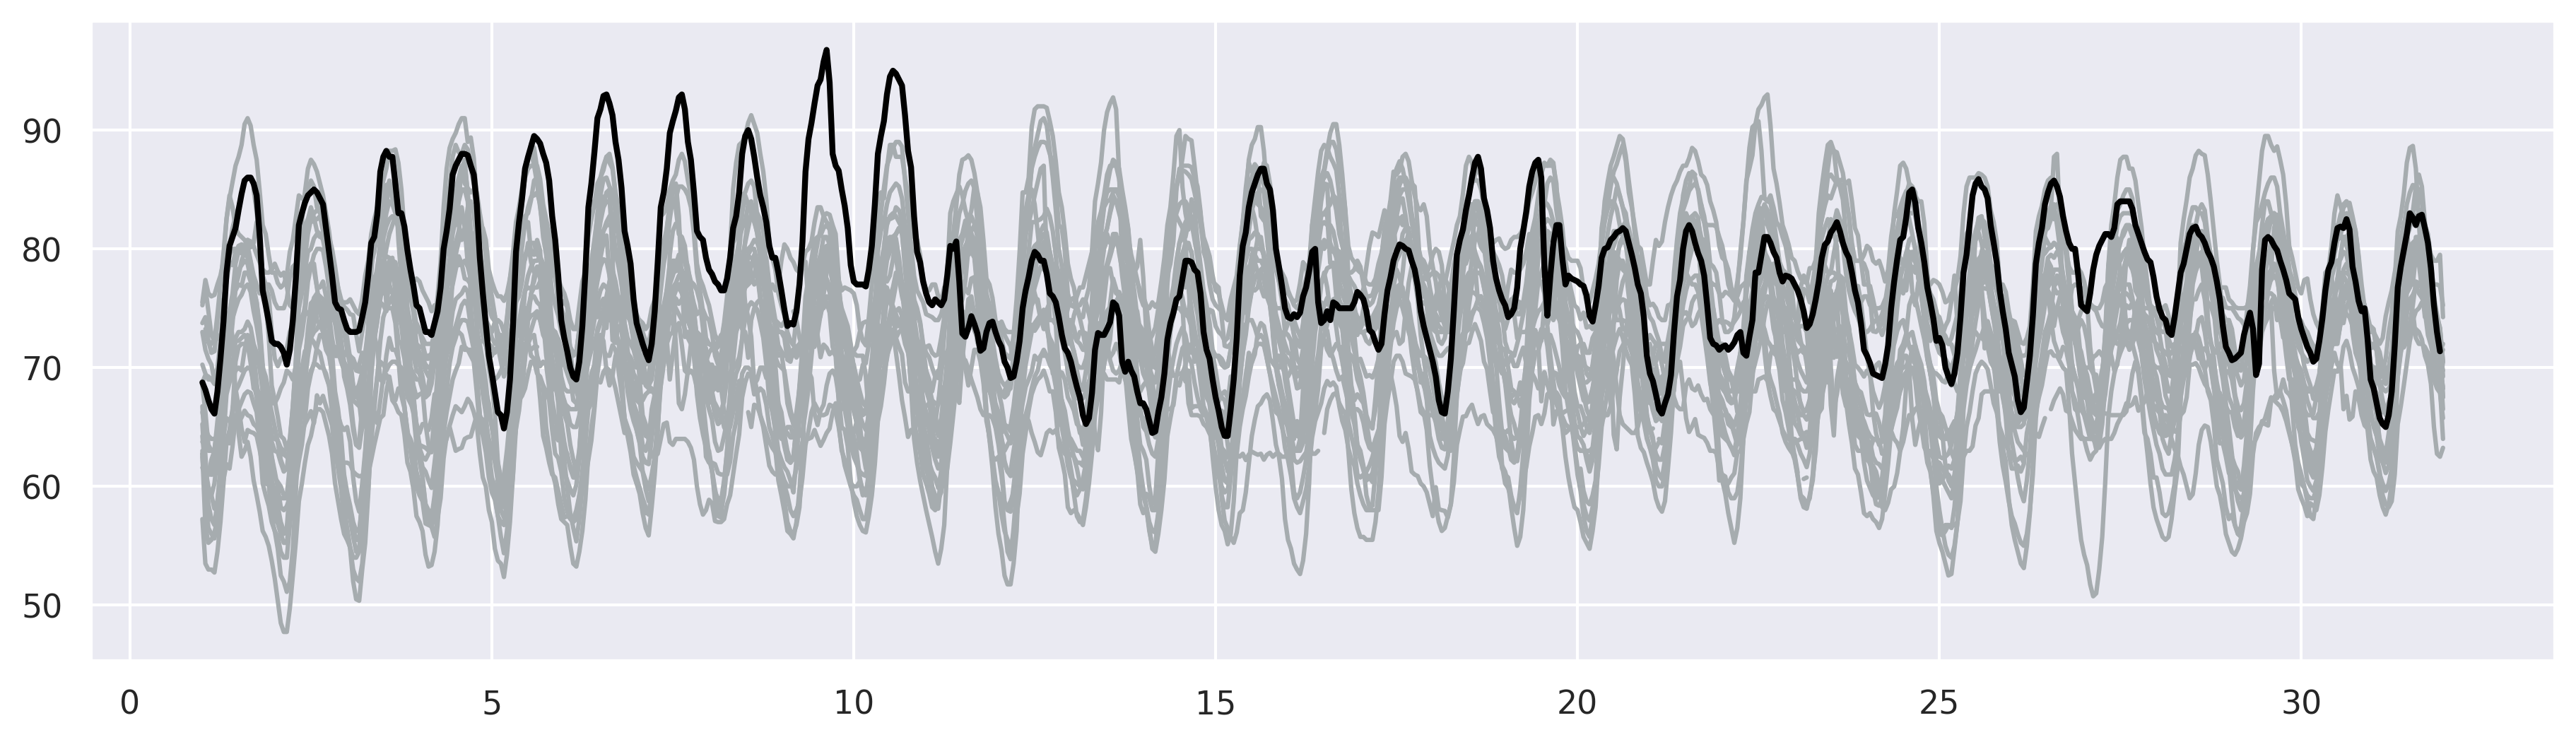

In [34]:
fig, ax = plt.subplots()
plt.plot(piv)

fig.set_dpi(300)
fig.set_figwidth(15)
# fig.legend([c[1] for c in piv.columns.to_list()])

# I want the last plot (most recent - i.e. 2020) to stand out. 
for index,line in enumerate(ax.lines):
    if index == (len(ax.lines)-1):
        # This is last plot - make it big and red
        line.set_linewidth(2)
        line.set_color("black")
    else:
        # This is not the last plot - make it grey
        line.set_color("#a6acaf")

plt.show()

Awesome, that definitely shows an interpretable visualization! 

What would be great as a next step would be a month drop-down and/or a stack of similar plots - one for each month. And the dropdown would be for the year to highlight. 

I think what I need to do for the plot aspect is to have one figure with twelve axes/subplots. Start with all the temperature data and abstract away the data manipulation logic 

In [35]:
def getMonthlyPivotData(month):
    '''
    Returns the subset of temperatureDate relevant to the target month, transformed into a 
    plottable pivot table.
    Assumes temperature_data is correctly populated in the upper scope. 
    '''
    # Get the relevant data lists
    filtered_dates, filtered_temps = list(zip(*[(d,t) for (d,t) in temperature_data if d.month == month]))
    
    # Wrangle the data into a Series indexed by date
    monthly_temp_series = pd.Series(filtered_temps, index = filtered_dates) 

    # Smooth the time series by taking the mean over a rolling triangular window of width 3 values
    monthly_temp_series = monthly_temp_series.rolling(window=3, center=True, win_type='triang').mean()

    # Convert to a DataFrame and add columns for monthly progress and year
    monthly_temp_series.name = 'MonthlyTemperature'
    df = monthly_temp_series.to_frame()
    df['Progress'] = df.index.day+df.index.hour/24
    df['Year'] = df.index.year

    # "Finally create a pivot table, which will have a column for each year and a row for each progress point
    piv = pd.pivot_table(df, index=['Progress'],columns=['Year'], values=['MonthlyTemperature'])

    return piv

In [36]:
# Test function with January
getMonthlyPivotData(1)

MonthlyTemperature                                         \
Year                    2001     2002       2003    2004       2005   
Progress                                                              
1.000000                 NaN  19.3750  31.875000  34.250  41.250000   
1.041667           19.375000  18.9375  30.916667  33.125  46.916667   
1.083333           19.000000  19.2500  30.125000  32.750  43.833333   
1.125000           18.583333  18.7500  29.500000  32.125  39.750000   
1.166667           17.250000  20.0000  29.250000  32.000  37.750000   
...                      ...      ...        ...     ...        ...   
31.791667          34.000000  32.0000  33.500000  20.125  22.250000   
31.833333          34.000000  31.6250  35.500000  19.000  21.250000   
31.875000          34.000000  31.5000  36.500000  19.000  19.750000   
31.916667          33.875000  31.2500  36.125000  18.875  17.375000   
31.958333          29.750000  31.2500  35.750000  26.000  19.750000   

                                                                           \
Year            2006       2007    2008       2009   2010    2011    2012   
Progress                                                                    
1.000000   28.500000  45.250000  30.500  12.750000  31.00  44.500  31.750   
1.041667   33.562500  50.500000  34.000   8.250000  32.00  52.125  37.875   
1.083333   33.666667  51.000000  33.750   7.750000  32.00  51.000  37.750   
1.125000   33.687500  51.000000  33.250   7.000000  32.00  50.750  38.750   
1.166667   33.625000  50.875000  33.375   8.083333  32.00  49.875  39.000   
...              ...        ...     ...        ...    ...     ...     ...   
31.791667  31.500000  23.333333  23.500  18.250000  22.00  13.875  51.750   
31.833333  31.000000  20.750000  23.250  21.000000  23.25  13.250  53.500   
31.875000  31.000000  20.250000  23.750  22.500000  23.75  13.000  54.000   
31.916667  30.666667  20.000000  24.000  23.125000  23.00  12.625  54.375   
31.958333  35.750000  23.500000  20.250  25.750000  29.50  19.000  49.000   

                                                                                
Year         2013       2014    2015    2016     2017    2018     2019    2020  
Progress                                                                        
1.000000   38.250  19.000000  23.250  29.750  39.7500  10.000  53.5000  23.750  
1.041667   31.875  17.500000  20.625  31.500  33.3750   3.000  51.6000  30.875  
1.083333   30.000  16.750000  20.750  32.000  32.0000   3.000  47.5000  30.250  
1.125000   29.250  16.125000  21.000  32.000  31.2500   2.500  44.5000  30.000  
1.166667   28.500  15.583333  22.250  31.500  31.0000   2.000  42.5625  30.375  
...           ...        ...     ...     ...      ...     ...      ...     ...  
31.791667  23.500  30.583333  24.000  54.625  28.5000  37.000   5.0000  31.500  
31.833333  23.000  30.250000  25.000  55.750  28.0000  38.250   4.9375  31.000  
31.875000  23.000  30.000000  25.000  56.000  28.0000  38.750   4.2500  31.000  
31.916667  22.500  30.000000  25.500  56.500  28.3125  39.375   3.3750  31.000  
31.958333  21.000  28.875000  26.625  51.250  28.7500  43.250   4.5000  31.000  

[744 rows x 20 columns]

In [45]:
def plotTemperaturesForYear(target_year):
    minTemp = min([d[1] for d in temperature_data])
    maxTemp = max([d[1] for d in temperature_data])
    tempPadding = 5 # padding for y axis

    fig, axes = plt.subplots(4,3)

    fig.set_dpi(300)
    fig.set_figwidth(15)
    fig.set_figheight(8)

    for i, axis in enumerate(axes.flat):
        plottableData = getMonthlyPivotData(i+1)
        maxyear = plottableData.columns[1][1]
        axis.plot(plottableData)
        axis.title.set_text(calendar.month_name[i+1])
        axis.xaxis.set_ticks([])
        axis.set_ylim([minTemp-tempPadding,maxTemp+tempPadding])
#         axis.set_ylabel("Temperature (F)")
        axis.yaxis.set_ticks([n for n in range(0,101,20)])
        # I want the last plot (most recent - i.e. 2020) to stand out. 
        for index,line in enumerate(axis.lines):
            lineYear = plottableData.columns[index][1]
            if lineYear == target_year:
                # This is last plot - make it big and red
                line.set_linewidth(2)
                line.set_color("black")
                # also bring the line to the front
                line.set_zorder(10)
            else:
                # This is not the last plot - make it grey
                line.set_color("#a6acaf")

    plt.show()

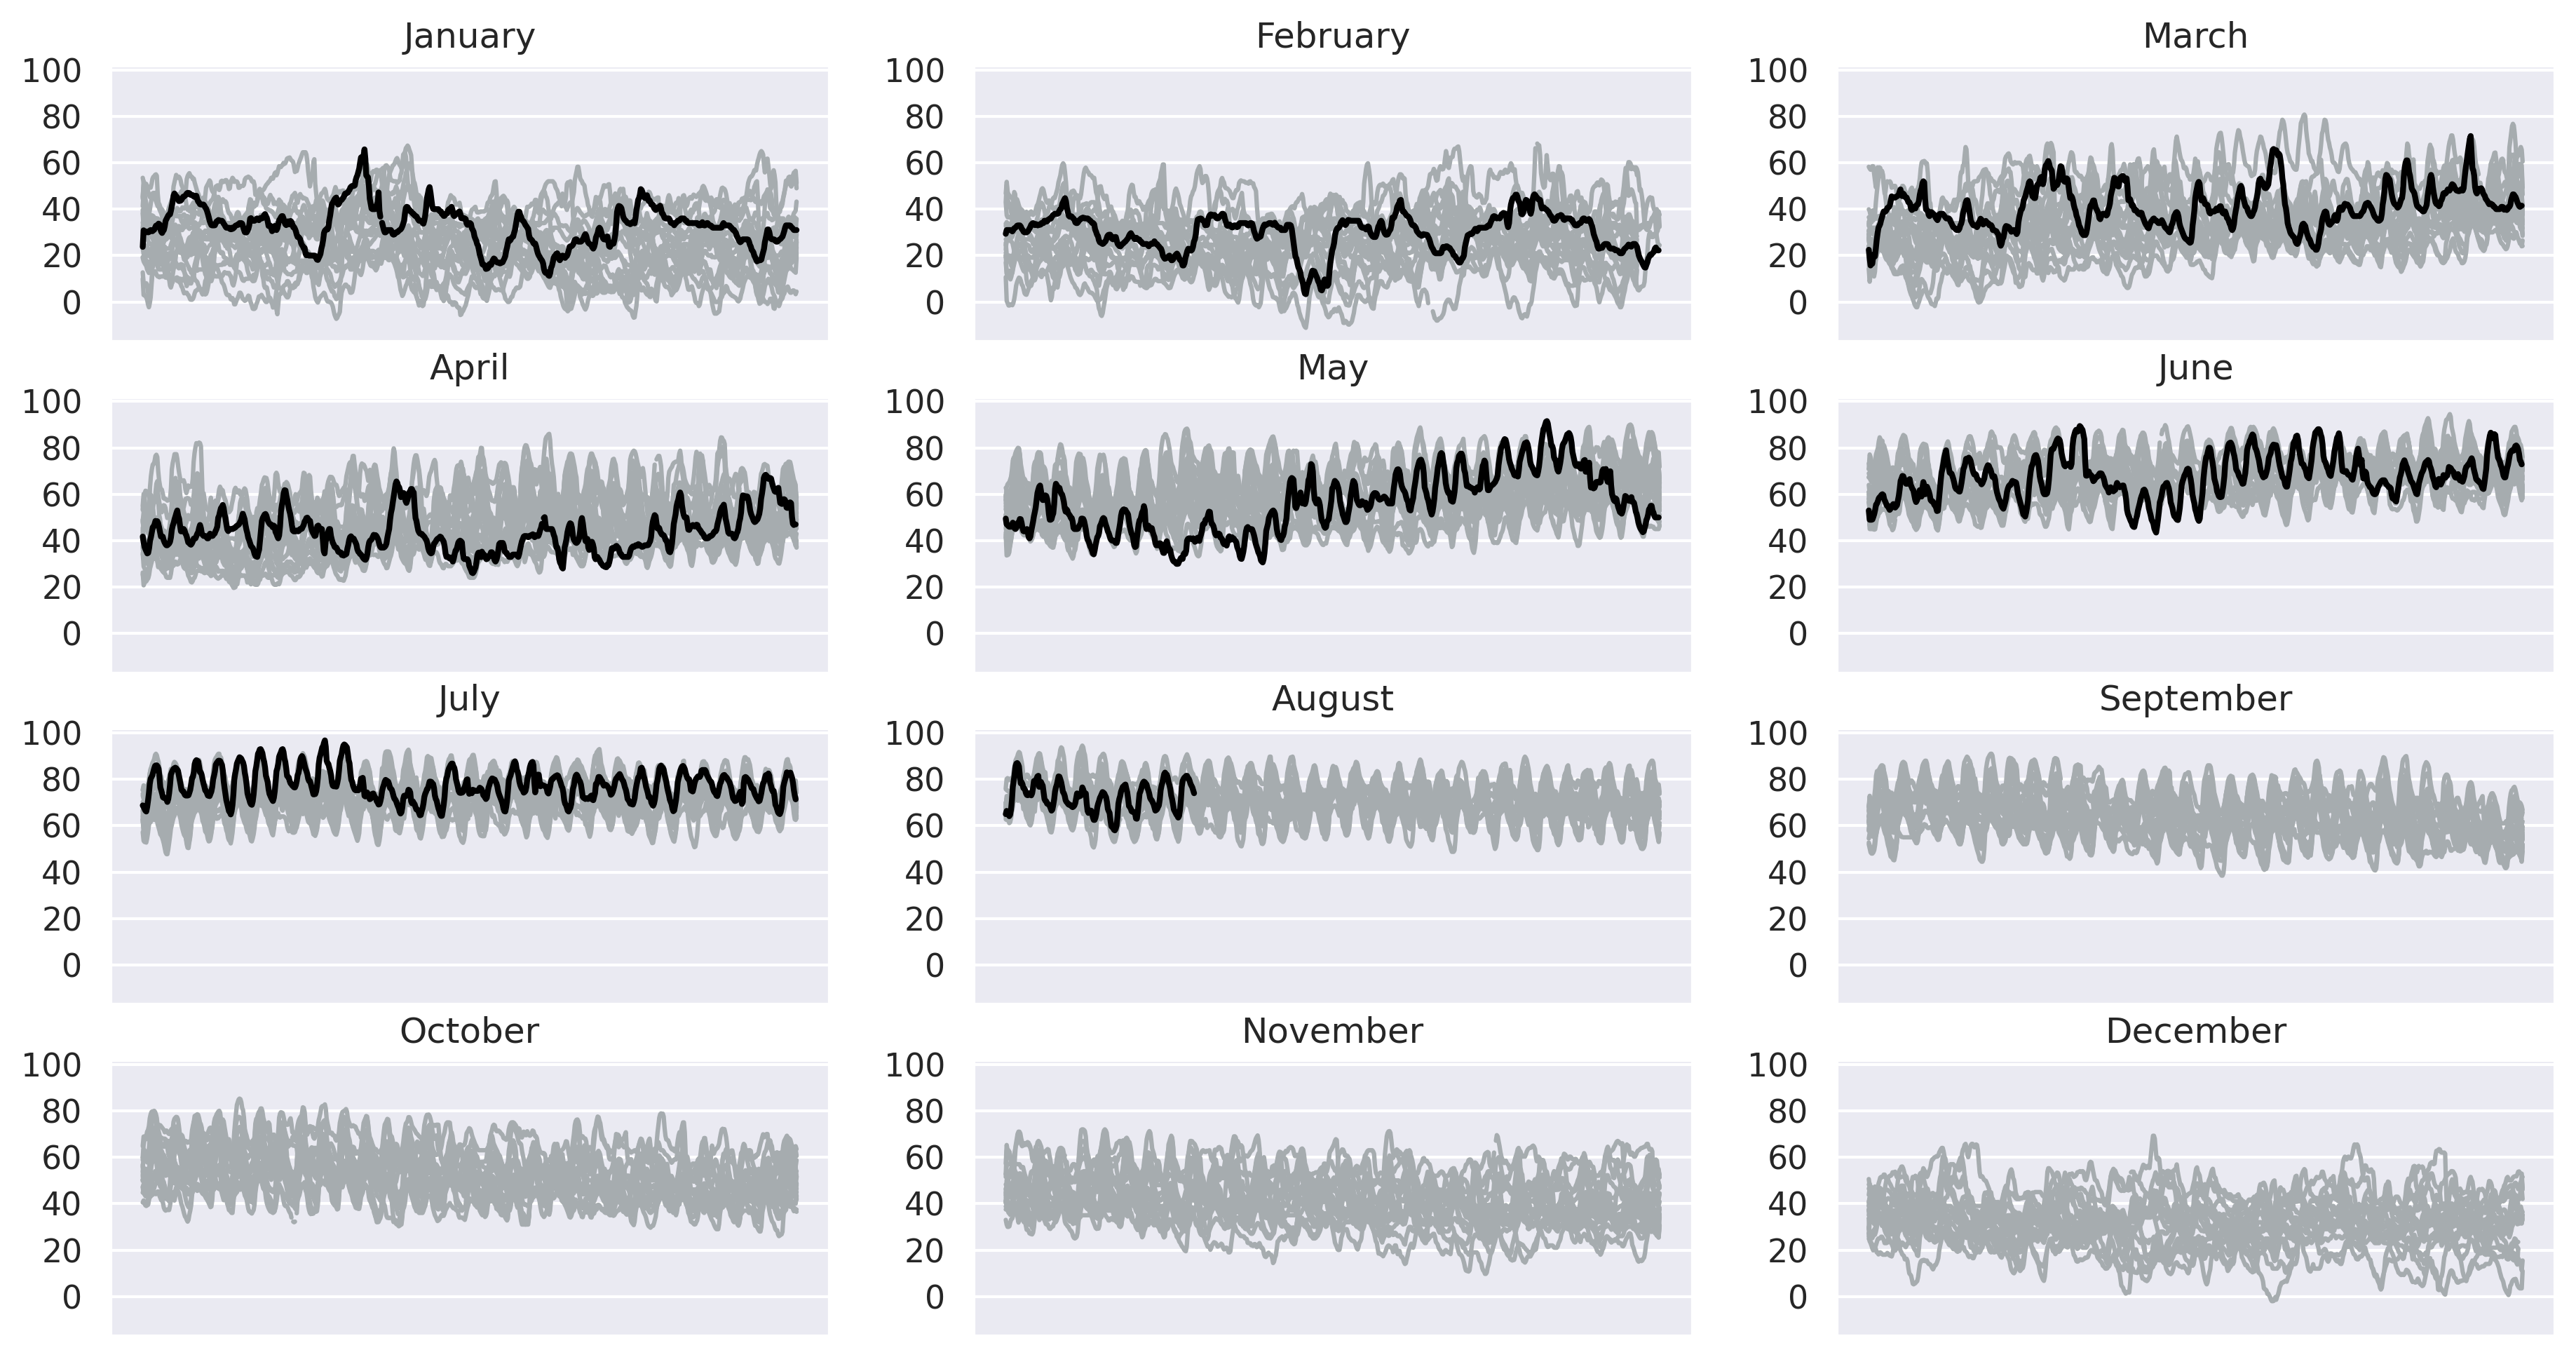

In [46]:
plotTemperaturesForYear(2020)

Alright, there's the 2020 proof of concept, now time to call the function with a dropdown!

In [47]:
@interact
def showYearPlots(year=[y for y in set([d[0].year for d in temperature_data])]):
    return plotTemperaturesForYear(year)

interactive(children=(Dropdown(description='year', options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 20…

**LIT AF**

Performance is not great though. When I click a year it takes a good few seconds before the figure updates. Now that I'm thinking about it, every press of the dropdown completely reloads and plots the data. If I could make it plot everything first and then just change the coloration and zorder of the lines based on the dropdown, that would probably help a great deal. 

Also, wouldn't it be cooool if it changed color based on the y value? Like peaks into the nineties appeared red and dips into the thirties were blue?

In [40]:
[i for i in range(0,101,20)]

[0, 20, 40, 60, 80, 100]